<a href="https://colab.research.google.com/github/lukeawayne/colabconnect/blob/main/Sequential_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Neural Network**

#### Importing

In [ ]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib.font_manager
from pyod.models.knn import KNN
from pyod.utils.data import generate_data, get_outliers_inliers
import anomalib
from PIL import Image
from matplotlib import image
from matplotlib import pyplot
import PIL
import cv2
from scipy import misc
import tensorflow as tf
import os
import imghdr
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy
from tensorflow.keras.models import Model

#### Saving out of memory errors

In [ ]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')   #
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

## Dodgy images

In [ ]:
rm -rf `find . -type d -name .ipynb_checkpoints`  #removes checkpoints

In [ ]:
#creates file
data_dir = 'data2'


#creates file exts
image_exts = ['jpeg','jpg', 'bmp', 'png']

os.listdir(data_dir)

['Pacemaker', 'Normal']

##### Takes out dodgy images

In [ ]:
for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try:
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts:
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e:
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

## Loading Images

In [ ]:
#establishes dataset
data = tf.keras.utils.image_dataset_from_directory('data2')

Found 479 files belonging to 2 classes.


In [ ]:
#allowing to iterate through the images
data_iterator = data.as_numpy_iterator()

#running the iterator
batch = data_iterator.next()

### Running the iterator

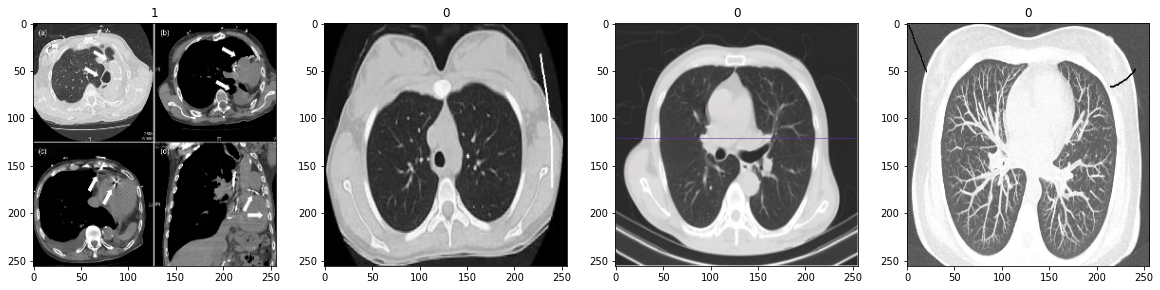

In [ ]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

## Scale the Data

In [ ]:
data = data.map(lambda x,y: (x/255, y))
data.as_numpy_iterator().next()

(array([[[[5.1764709e-01, 5.3333336e-01, 5.3725493e-01],
          [5.1764709e-01, 5.3333336e-01, 5.3725493e-01],
          [5.1764709e-01, 5.3333336e-01, 5.3725493e-01],
          ...,
          [7.0521599e-01, 7.2090226e-01, 7.3266697e-01],
          [7.2430301e-01, 7.3998928e-01, 7.5175399e-01],
          [7.4901962e-01, 7.6470590e-01, 7.7647060e-01]],
 
         [[5.1764709e-01, 5.3333336e-01, 5.3725493e-01],
          [5.1764709e-01, 5.3333336e-01, 5.3725493e-01],
          [5.1764709e-01, 5.3333336e-01, 5.3725493e-01],
          ...,
          [7.5376874e-01, 7.6945502e-01, 7.8121972e-01],
          [8.3578992e-01, 8.5147619e-01, 8.6324090e-01],
          [7.9810816e-01, 8.1379443e-01, 8.2555914e-01]],
 
         [[5.1764709e-01, 5.3333336e-01, 5.3725493e-01],
          [5.1764709e-01, 5.3333336e-01, 5.3725493e-01],
          [5.1764709e-01, 5.3333336e-01, 5.3725493e-01],
          ...,
          [8.6172438e-01, 8.7741065e-01, 8.8917536e-01],
          [8.6035907e-01, 8.7604541e-

## Split Data

In [ ]:
len(data)

15

In [ ]:
#creating the amount of data to use for each subject
train_size = int(len(data)*.7)
val_size = int(len(data)*.3)
test_size = int(len(data)*.1)

#creating data to use
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

## Deep Learning Model

## **maybe use something other than sequential**

In [ ]:
from tensorflow.keras.applications import VGG16

In [ ]:
vgg = VGG16(include_top=False)

In [ ]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [ ]:
#creating the model
model = Sequential()

#setting standards for the model
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [ ]:
#compiling and showing summary
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 127, 127, 16)     0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 30, 30, 16)      

## Train

In [ ]:
#creating logs directory
logdir='logs'

#creating callback for model
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

#fitting the model
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
10/10 [==============================] - 24s 2s/step - loss: 0.6709 - accuracy: 0.6938 - val_loss: 0.6610 - val_accuracy: 0.6953
Epoch 2/20
10/10 [==============================] - 18s 2s/step - loss: 0.5383 - accuracy: 0.6969 - val_loss: 0.3601 - val_accuracy: 0.7891
Epoch 3/20
10/10 [==============================] - 21s 2s/step - loss: 0.3747 - accuracy: 0.7688 - val_loss: 0.3857 - val_accuracy: 0.7656
Epoch 4/20
10/10 [==============================] - 21s 2s/step - loss: 0.3148 - accuracy: 0.8250 - val_loss: 0.2530 - val_accuracy: 0.8672
Epoch 5/20
10/10 [==============================] - 27s 2s/step - loss: 0.2103 - accuracy: 0.9406 - val_loss: 0.1521 - val_accuracy: 0.9609
Epoch 6/20
10/10 [==============================] - 22s 2s/step - loss: 0.1344 - accuracy: 0.9594 - val_loss: 0.2037 - val_accuracy: 0.9062
Epoch 7/20
10/10 [==============================] - 20s 2s/step - loss: 0.0998 - accuracy: 0.9688 - val_loss: 0.0981 - val_accuracy: 0.9688
Epoch 8/20
10/10 [==

## Plot Performace

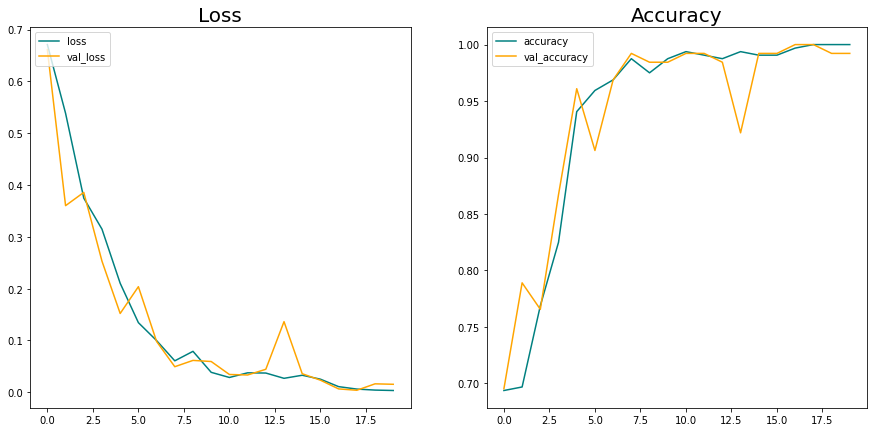

In [ ]:
#plotting
fig, ax = plt.subplots(ncols=2, figsize=(15,7))

#loss
ax[0].plot(hist.history['loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_loss'], color='orange', label='val_loss')
ax[0].set_title("Loss", fontsize=20)
ax[0].legend(loc="upper left")

#accuracy
ax[1].plot(hist.history['accuracy'], color='teal', label='accuracy')
ax[1].plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
ax[1].set_title('Accuracy', fontsize=20)
ax[1].legend(loc="upper left")

## Evaluate

In [ ]:
#initilizing resutls
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

#running through the model with different images
for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

#printing setup
print(pre.result(), re.result(), acc.result())

tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32)


## Test

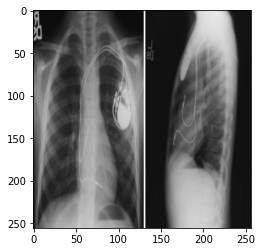

In [ ]:
#loading images
img = cv2.imread('4.png')
img2 = cv2.imread('pacemakertest.jpeg')

#creating test value
resize = tf.image.resize(img2, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [ ]:
#predicting model & looking at value
yhat = model.predict(np.expand_dims(resize/255, 0))
yhat

array([[0.9998835]], dtype=float32)

In [ ]:
#truth statement if pacemaker is present or not
if yhat > 0.5:
    print(f'Pacemaker Present')
else:
    print(f'No Pacemaker Present')

Pacemaker Present


## Saving Model

In [ ]:
#from tensorflow.keras.models import load_model

In [ ]:
#model.save(os.path.join('models','imageclassifier.h5'))

In [ ]:
#new_model = load_model('imageclassifier.h5')

In [ ]:
#new_model.predict(np.expand_dims(resize/255, 0))